# Keras

Keras is a high-level neural networks library, written in Python and capable of running on top of either TensorFlow or Theano. It was developed with a focus on enabling fast experimentation. Being able to go from idea to result with the least possible delay is key to doing good research.

https://keras.io/

In [1]:
import keras

Using TensorFlow backend.


# VGG16

- http://www.robots.ox.ac.uk/~vgg/research/very_deep/
- https://arxiv.org/pdf/1409.1556.pdf

![VGG16 Architecture](https://heuritech.files.wordpress.com/2016/02/vgg16.png?w=470)


In [2]:
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
import cv2, numpy as np

def VGG_16(weights_path=None):
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(3,224,224)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation='softmax'))

    if weights_path:
        model.load_weights(weights_path)

    return model

Вспомогательные функции

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

def get_image(path):
    im = cv2.resize(cv2.imread(path), (224, 224)).astype(np.float32)
    im[:,:,0] -= 103.939
    im[:,:,1] -= 116.779
    im[:,:,2] -= 123.68
    im = im.transpose((2,0,1))
    return im

def draw_image(path, title=""):
    im = cv2.resize(cv2.imread(path), (224, 224))
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.imshow(im)
    plt.title(path + " " + str(title))

загружаем веса сети и инициализируем модель

In [4]:
# Test pretrained model
model = VGG_16('vgg16_weights.h5')
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy')

In [5]:
import os
import operator

from scipy.spatial.distance import cosine

In [10]:
from keras import backend as K

def get_layer_output(model, index, x):
    return K.function([model.layers[0].input], [model.layers[index].output])([x])[0]

In [7]:
class ImageDataBase:
    batch_size = 10
    
    def __init__(self, path, model, index):
        self.index = index
        
        self.files_all = map(lambda x: path + x, os.listdir(path))
        self.n_files_all = len(self.files_all)
        
        out_layer = model.get_layer(index=self.index)
        self.out_dim = reduce(operator.mul, out_layer.output_shape[1:])
        
        self.features = np.zeros(shape=(self.n_files_all, self.out_dim), dtype=float)
        n_images = 0
        
        for batch_i in range(0, self.n_files_all, self.batch_size):
            images = map(get_image, self.files_all[batch_i: batch_i + self.batch_size])
            images = get_layer_output(model, self.index, images)
            images = images.reshape(-1, self.out_dim)
            
            self.features[batch_i: batch_i + self.batch_size] = images
            
            n_images += len(images)
            print "\r{} of {} images processed...".format(n_images, self.n_files_all),
        
    def similar(self, path, n=10):
        plt.figure(0)
        draw_image(path)
        
        x = get_layer_output(model, self.index, [get_image(path)])[0].reshape(-1)
        similarity = [cosine(x, y) for y in self.features]
        
        images_best = np.argsort(similarity)[:n]
        for i, img_index in enumerate(images_best):
            plt.figure(i + 1)
            draw_image(self.files_all[img_index])

In [8]:
imgage_base = ImageDataBase(path='./shmot_small/', model=model, index=31)

213 of 213 images processed...


# TODO Put your code here 
    

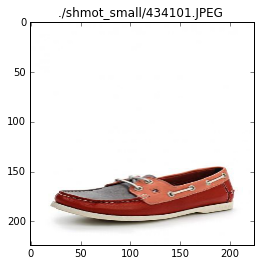

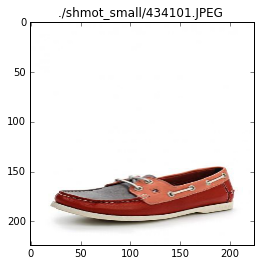

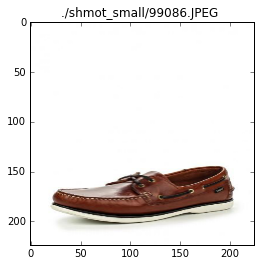

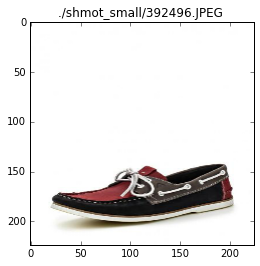

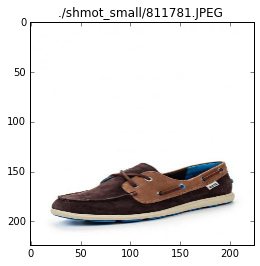

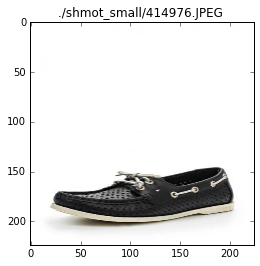

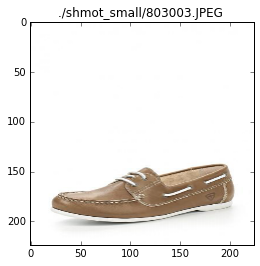

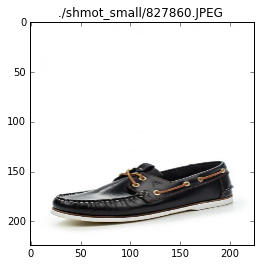

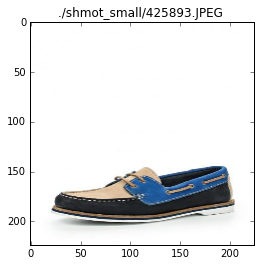

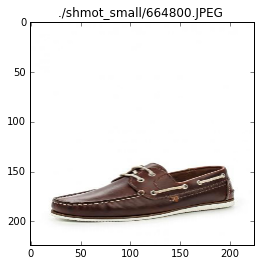

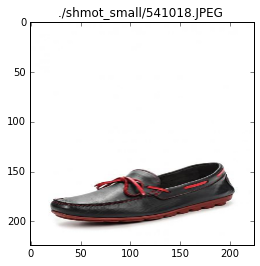

In [17]:
imgage_base.similar('./shmot_small/434101.JPEG', n=10)

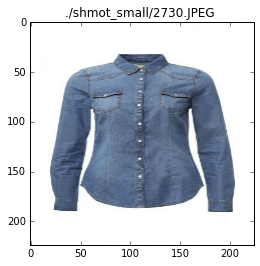

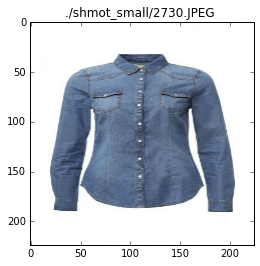

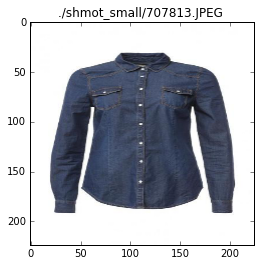

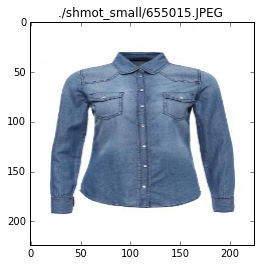

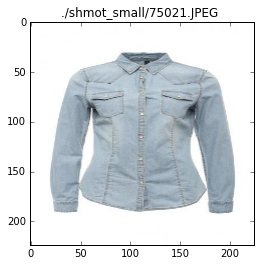

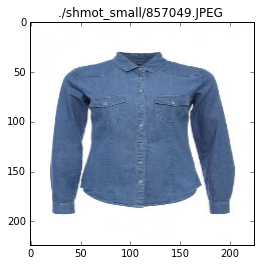

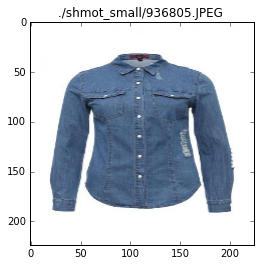

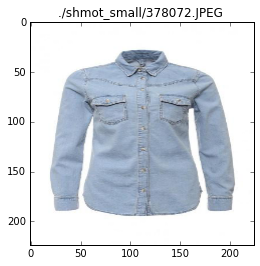

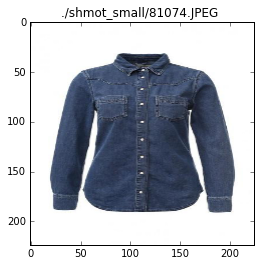

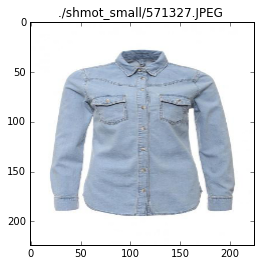

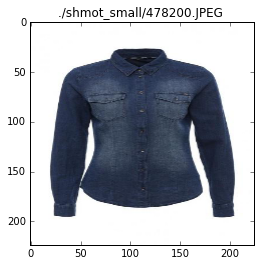

In [12]:
imgage_base.similar('./shmot_small/2730.JPEG', n=10)

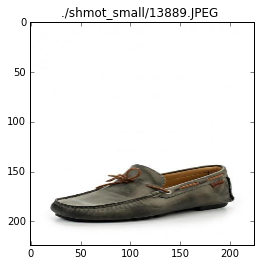

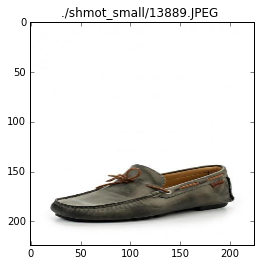

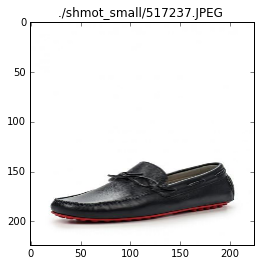

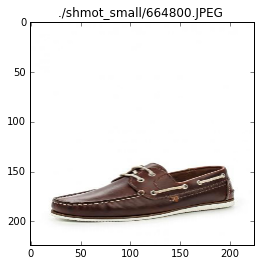

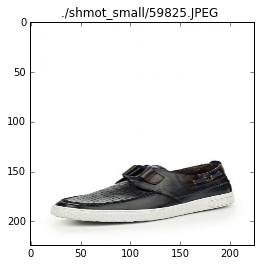

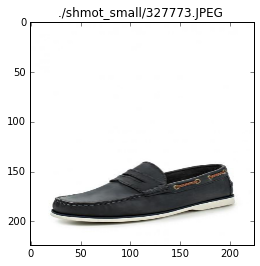

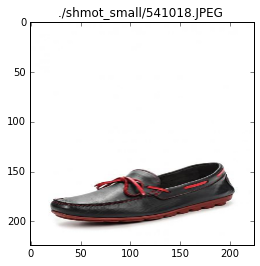

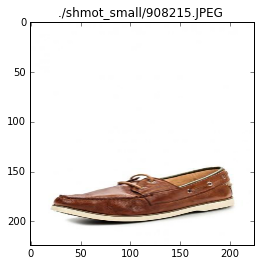

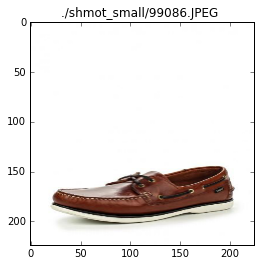

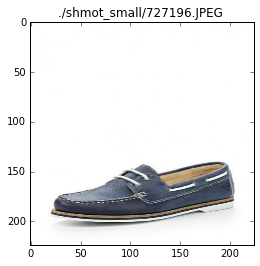

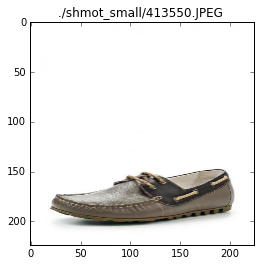

In [13]:
imgage_base.similar('./shmot_small/13889.JPEG', n=10)